### Import các thư viện cần thiết

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


### Nhập và xử lý dữ liệu

#### Đọc dữ liệu từ dataset

In [2]:
data = pd.read_csv('../dataset/data.csv')
print(f"Kích thước dữ liệu: {data.shape}")
print(f"Số cột dữ liệu: {data.shape[1]}")
print(f"Số dòng dữ liệu: {data.shape[0]}")

print("\nMẫu dữ liệu:")
data.head()

Kích thước dữ liệu: (246945, 378)
Số cột dữ liệu: 378
Số dòng dữ liệu: 246945

Mẫu dữ liệu:


,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Kiểm tra giá trị null

In [3]:
null_counts = data.isnull().sum()
print(f"Tổng số giá trị null: {null_counts.sum()}")

Tổng số giá trị null: 0


#### Thống kê số lượng bệnh và triệu chứng

In [4]:
disease_counts = data['diseases'].value_counts()

symptom_cols = data.columns[1:]
symptom_counts = data[symptom_cols].sum().sort_values(ascending=False)

print("Số lượng bệnh: ", disease_counts.shape[0])
print("Số triệu chứng: ", symptom_counts.shape[0])

Số lượng bệnh:  773
Số triệu chứng:  377


#### Xóa các dòng bị trùng

In [5]:
data_no_first_col = data.iloc[:, 1:]

duplicates = data_no_first_col.duplicated(keep='first')

print(f"Số dòng bị trùng: {duplicates.sum()}")

data = data[~duplicates].reset_index(drop=True)

print(f"Kích thước dữ liệu còn lại sau khi xóa  các dòng bị trùng: {data.shape}")


Số dòng bị trùng: 77057
Kích thước dữ liệu còn lại sau khi xóa  các dòng bị trùng: (169888, 378)


#### Thống kê số lượng bệnh và triệu chứng sau khi xóa các dòng bị trùng

In [6]:
desc = disease_counts.describe()

desc_df = pd.DataFrame(desc).T

desc_df.columns = ['Số lượng bệnh', 'Trung bình', 'Độ lệch chuẩn', 'Nhỏ nhất',
                   '25%', 'Trung vị', '75%', 'Lớn nhất']

display(desc_df)



,Số lượng bệnh,Trung bình,Độ lệch chuẩn,Nhỏ nhất,25%,Trung vị,75%,Lớn nhất
count,773.0,319.463131,351.691549,1.0,30.0,168.0,505.0,1219.0


#### In ra những bệnh có ít hơn 5 mẫu dữ liệu

In [7]:
disease_counts = data['diseases'].value_counts()
rare_diseases = disease_counts[disease_counts < 5]
print("=== THỐNG KÊ BỆNH HIẾM (< 5 mẫu) ===")
print(f"Tổng số loại bệnh hiếm: {len(rare_diseases)}")
print(f"Tổng số mẫu của các bệnh hiếm: {rare_diseases.sum()}")
print("\n=== CHI TIẾT TỪNG BỆNH ===")
print(rare_diseases)

=== THỐNG KÊ BỆNH HIẾM (< 5 mẫu) ===
Tổng số loại bệnh hiếm: 110
Tổng số mẫu của các bệnh hiếm: 215

=== CHI TIẾT TỪNG BỆNH ===
diseases
malaria                         4
glucocorticoid deficiency       4
vesicoureteral reflux           4
placenta previa                 4
spinocerebellar ataxia          4
                               ..
dengue fever                    1
rheumatic fever                 1
rocky mountain spotted fever    1
open wound of the jaw           1
turner syndrome                 1
Name: count, Length: 110, dtype: int64


#### Xóa các bệnh có ít dữ liệu mẫu

In [8]:
data = data[~data['diseases'].isin(rare_diseases.index)]
print(f"Kích thước dữ liệu còn lại sau khi xóa các bệnh hiếm: {data.shape}")
disease_counts = data['diseases'].value_counts()
print(f"Số bệnh còn lại: {disease_counts.shape[0]}")

Kích thước dữ liệu còn lại sau khi xóa các bệnh hiếm: (169673, 378)
Số bệnh còn lại: 639


#### Lưu lại danh sách bệnh và triệu chứng

In [9]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs("../data_info", exist_ok=True)

# Ghi danh sách bệnh vào file
disease_list = disease_counts.index.tolist()
with open("../data_info/disease_list.txt", "w", encoding="utf-8") as f:
    for disease in disease_list:
        f.write(f"{disease}\n")
disease_list

['hypoglycemia',
 'acute pancreatitis',
 'infectious gastroenteritis',
 'marijuana abuse',
 'bursitis',
 'injury to the leg',
 'benign prostatic hyperplasia (bph)',
 'obstructive sleep apnea (osa)',
 'vulvodynia',
 'concussion',
 'complex regional pain syndrome',
 'spondylosis',
 'injury to the arm',
 'gout',
 'gastrointestinal hemorrhage',
 'conjunctivitis due to allergy',
 'liver disease',
 'arthritis of the hip',
 'dental caries',
 'peripheral nerve disorder',
 'anxiety',
 'esophagitis',
 'cholecystitis',
 'acute bronchiolitis',
 'strep throat',
 'sprain or strain',
 'nose disorder',
 'vaginal cyst',
 'diverticulitis',
 'fungal infection of the hair',
 'pneumonia',
 'spontaneous abortion',
 'acute bronchitis',
 'eczema',
 'cystitis',
 'spinal stenosis',
 'noninfectious gastroenteritis',
 'acute sinusitis',
 'vaginitis',
 'problem during pregnancy',
 'asthma',
 'panic disorder',
 'stye',
 'actinic keratosis',
 'gum disease',
 'allergy',
 'pyelonephritis',
 'injury to the trunk',
 'ca

In [10]:
symptom_list = symptom_cols.tolist()
with open("../data_info/symptom_list.txt", "w", encoding="utf-8") as f:
    for symptom in symptom_list:
        f.write(f"{symptom}\n")
symptom_list

['anxiety and nervousness',
 'depression',
 'shortness of breath',
 'depressive or psychotic symptoms',
 'sharp chest pain',
 'dizziness',
 'insomnia',
 'abnormal involuntary movements',
 'chest tightness',
 'palpitations',
 'irregular heartbeat',
 'breathing fast',
 'hoarse voice',
 'sore throat',
 'difficulty speaking',
 'cough',
 'nasal congestion',
 'throat swelling',
 'diminished hearing',
 'lump in throat',
 'throat feels tight',
 'difficulty in swallowing',
 'skin swelling',
 'retention of urine',
 'groin mass',
 'leg pain',
 'hip pain',
 'suprapubic pain',
 'blood in stool',
 'lack of growth',
 'emotional symptoms',
 'elbow weakness',
 'back weakness',
 'pus in sputum',
 'symptoms of the scrotum and testes',
 'swelling of scrotum',
 'pain in testicles',
 'flatulence',
 'pus draining from ear',
 'jaundice',
 'mass in scrotum',
 'white discharge from eye',
 'irritable infant',
 'abusing alcohol',
 'fainting',
 'hostile behavior',
 'drug abuse',
 'sharp abdominal pain',
 'feeling 

### Huấn luyện mô hình

#### Chia tập train và test

In [11]:
X = data.iloc[:, 1:].astype(np.float32)  # Tất cả các cột trừ cột đầu tiên (diseases)
y = data.iloc[:, 0]   # Cột đầu tiên (diseases)

# Chuyển đổi nhãn bệnh thành số
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Số lượng nhãn bệnh: {len(le.classes_)}")

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

Số lượng nhãn bệnh: 639
Kích thước tập huấn luyện: (135738, 377)
Kích thước tập kiểm tra: (33935, 377)


#### Tiến hành huấn luyện mô hình

In [12]:
# Khởi tạo và huấn luyện Random Forest
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Đang huấn luyện mô hình Random Forest...")
rf_model.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = rf_model.predict(X_test)
print("\n=== BÁO CÁO PHÂN LOẠI ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Đang huấn luyện mô hình Random Forest...

=== BÁO CÁO PHÂN LOẠI ===
                                                 precision    recall  f1-score   support

                      abdominal aortic aneurysm       1.00      1.00      1.00         7
                               abdominal hernia       0.96      0.98      0.97        53
                                abscess of nose       0.96      0.88      0.92        25
                            abscess of the lung       0.00      0.00      0.00         1
                         abscess of the pharynx       0.91      0.78      0.84        27
                           acanthosis nigricans       1.00      1.00      1.00         1
                                      acariasis       1.00      1.00      1.00         1
                                      achalasia       1.00      0.75      0.86         4
                                           acne       0.89      0.95      0.92        43
                              actinic ker

c:\Users\VAN THIEU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VAN THIEU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VAN THIEU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

#### Ma trận nhầm lẫn

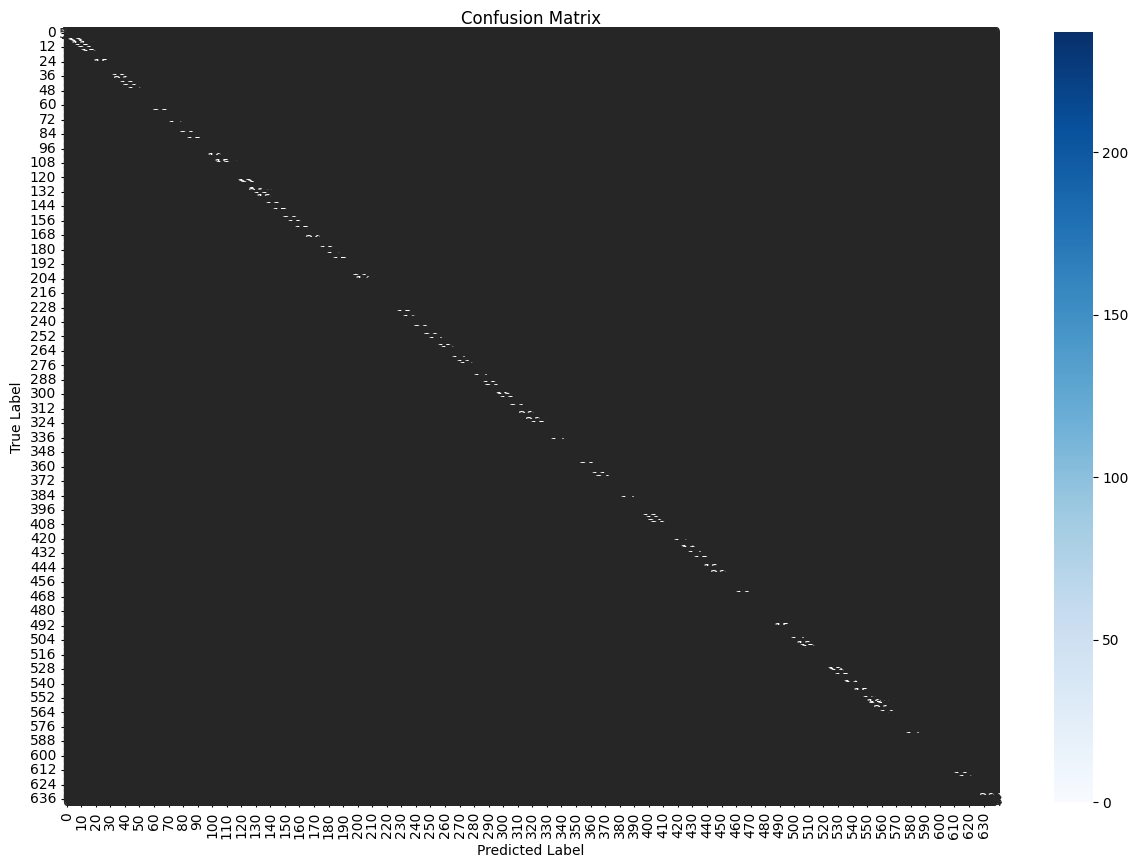

In [13]:
# Vẽ confusion matrix
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Những loại bệnh có triệu chứng quan trọng nhất

=== TOP 20 TRIỆU CHỨNG QUAN TRỌNG NHẤT ===
                              feature  importance
50                           headache    0.019605
49                           vomiting    0.016140
47               sharp abdominal pain    0.015204
4                    sharp chest pain    0.013625
15                              cough    0.013317
5                           dizziness    0.013031
2                 shortness of breath    0.012497
93                          back pain    0.012291
51                             nausea    0.011874
168                             fever    0.011860
198                           fatigue    0.009388
3    depressive or psychotic symptoms    0.009268
75            abnormal appearing skin    0.009050
140                          weakness    0.008847
280                         skin rash    0.008833
107                  peripheral edema    0.008441
124            problems with movement    0.008435
25                           leg pain    0.008322
16     

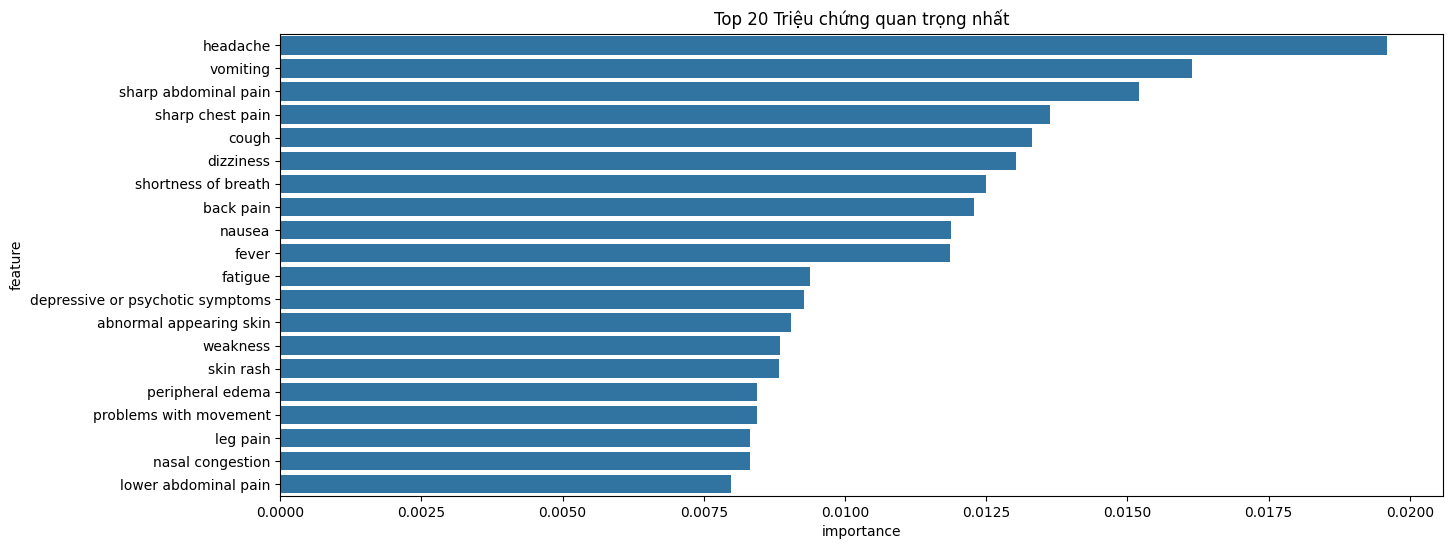

In [17]:
# Xác định các triệu chứng quan trọng nhất
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== TOP 20 TRIỆU CHỨNG QUAN TRỌNG NHẤT ===")
print(feature_importance.head(20))

# Vẽ biểu đồ feature importance
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Triệu chứng quan trọng nhất')
plt.show()

### Demo dự đoán

In [18]:
def predict_disease(model, symptoms, le, X_columns):
    # Tạo vector đặc trưng
    input_features = np.zeros(len(X_columns))
    for symptom in symptoms:
        if symptom in X_columns:
            idx = X_columns.get_loc(symptom)
            input_features[idx] = 1

    # Dự đoán
    pred = model.predict([input_features])
    pred_proba = model.predict_proba([input_features])

    # Lấy top 3 bệnh có xác suất cao nhất
    top_3_idx = np.argsort(pred_proba[0])[-3:][::-1]

    print("\n=== KẾT QUẢ DỰ ĐOÁN ===")
    print("Top 3 bệnh có khả năng cao nhất:")
    for idx in top_3_idx:
        print(f"{le.classes_[idx]}: {pred_proba[0][idx]*100:.2f}%")

    return le.classes_[pred[0]], pred_proba[0]

# Ví dụ sử dụng
symptoms = ['sneezing', 'fever', 'cough', 'headache', 'nasal congestion', 'nausea']
predicted_disease, probabilities = predict_disease(
    rf_model, symptoms, le, X_train.columns
)


=== KẾT QUẢ DỰ ĐOÁN ===
Top 3 bệnh có khả năng cao nhất:
seasonal allergies (hay fever): 44.00%
tracheitis: 24.00%
abscess of the pharynx: 10.00%


c:\Users\VAN THIEU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\VAN THIEU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Lưu mô hình để sử dụng

In [16]:
# Tạo thư mục models nếu chưa tồn tại
os.makedirs("../models", exist_ok=True)

# Lưu mô hình Random Forest với mức nén cao nhất (9)
joblib.dump(rf_model, '../models/random_forest_model.joblib', compress=3)
print("Đã lưu mô hình Random Forest")

# Lưu Label Encoder với mức nén cao nhất
joblib.dump(le, '../models/label_encoder.joblib', compress=3)
print("Đã lưu Label Encoder")

Đã lưu mô hình Random Forest
Đã lưu Label Encoder
